In [93]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.stats import norm
from random import *
from matplotlib.pylab import *
%matplotlib inline

In [94]:
"""Constants"""
eps0 = 8.854e-12 #[F/m]
e = 1.60217662e-19 #elementary charge [C]
h = 6.62607004e-34 #Planck's constant [Js]
m_e = 9.10938356e-31 #electron mass [kg]

In [95]:
"""Material dependant constants:"""
'''Fluid'''
fluid_density = 0.164 #helium
particle_mass = 6.6464764e-27 #helium [kg]
eta = 3.12e-5 #shear viscosity = kinematic viscosity * denisty of fluid
beta = 0 #bulk viscoisty
kinematic_viscosity = 3.12e-5/fluid_density
eps_rel = 1 #relative permittivity
eps = eps0 * eps_rel
k = 1/(4*math.pi*eps)

'''QDs'''
#(InAs/GaAs QDs)
Rt = (10*h)/(e**2) #tunneling resistance (made up value)
m_eeff = 0.067 * m_e #electron effective mass [kg]
m_heff = 0.34 * m_e #hole effective mass [kg]
E_g = 0.36 * 1.60217662e-19 #band gap of QD (InAs bulk) [J]


'''Inner section'''
cap_d = 0.394    #capacitance density in [F/m^2] of inner segment capacitors
rho = 3e3 # desity of inner disc material (approxmiate) [kg/m^3]
R_c = 1 #capacitor circuit resistance

In [96]:
"""Initial parameter functions"""
def seperation_angle(n):
    return ( (2*math.pi)/n )

def setup_radius(sep, diam, PHI):
    return ( (sep + diam)/(2 * math.sin(PHI/2)) )

def cog_length( Rp, PHI):
    r = ( Rp*math.sin(PHI) )/(4*math.sin(PHI/2))
    return r

def width( Rp, PHI):
    w = ( Rp*math.sin(PHI) )/2
    return w

def inertia( rho, thc, Rp):
    """Calculates inertia of inner rotating disk"""
    I = 0.5 * rho * math.pi * thc * ( Rp ** 4 ) #for disc, needs to be changed for cog shape
    return I

In [97]:
"""Motor setup functions"""

def permanent_charge_magnitude( r, width, cap_d, cap_vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = r * width
    capacitance = cap_d * segment_area #capacitance of one segment
    stored_charge = capacitance * cap_vol #stored charge in one segment
    return stored_charge

def permanent_charges( Rp, p , cap_d, cap_vol, width, r):
    """Initializes permanent charge elements"""
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( r, width, cap_d, cap_vol)
        else:
            p_ch = -permanent_charge_magnitude( r, width, cap_d, cap_vol)
        PCs.update({i:[xp,yp,theta, p_ch]}) #dictionary containing all info of permanent charges
    return PCs

def quantum_dots( n, e, noc):
    """Initializes quantum dot elements"""
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if i in range(1, n, 4): #will result in +ve torque ==> turning anti-clockwise
            q_ch = noc*e
        elif i in range(3, n, 4):
            q_ch = -noc*e
        else:
            q_ch = 0
        QDs.update({i:[x,y,fi,q_ch]}) #dictionary containing all info on QDs
    return QDs

In [98]:
"""Initial parameters:"""
'''QDs'''
diam = 10e-9 #diameter of QDs [m]
sep = 130e-9 #seperation of QDs [m] (corresponds to motor dead zone)
n = 24   #number of QDs [no unit]
PHI = seperation_angle(n) #angle of seperation between QDs
R = setup_radius(sep, diam, PHI)  #radius of QD setup [m] 5.36290830288e-07
noc = 6 #number of charge carriers contributing to net charge of QD
'''Inner section'''
p = int(n/2)   #number of permanent charges (PCs) [no unit]
r0 = 110e-9
Rp = R - r0   #radius of rotating disc [m]
w = width( Rp, PHI )#cog "tooth"/capacitor arm width [m]
r = cog_length( Rp, PHI)    #length of the cog shaft [m]

thc = 30e-9   #approximate thickeness of inner disc [m]
cap_vol = 1   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments) [V]
I = inertia( rho, thc, Rp) #inertia of inner rotating disk

'''Medium'''
constant =  p * 1.08e-11  #coefficient of drag force function

In [99]:
'''1D Distribution'''
def max_boltz(v, part_m):
    prob = np.exp((-part_m*(v**2))/(2*kb*T))*((part_m/(2*np.pi*kb*T))**(1/2))
    return prob

In [100]:
'''EFFECTS OF BROWNIAN MOTION'''
Rc = Rp - r    #radius of the rotor minus shaft
T = 300
particle_mass = 6.6464764e-27 #helium [kg]
kb = 1.38064852e-23

def no_gas_particles(p_ch_sep_angle, width, r, dens, part_m):
    mass_gas = dens*thc * ((p_ch_sep_angle/2)*((Rp**2)-(Rc**2))-w*r)
    no = int((mass_gas/part_m)//1)
    return no


def velocity(nn):
    theta_list = np.arange(0, 2*np.pi, 2*np.pi/nn) #randomise angle in the horizontal plane (0 --> 2pi)
    fi_list = np.arange(0, np.pi, np.pi/nn)   #randomize angle in the vertical plane (0 --> pi)
    rand1 = randint(0, nn-1)
    rand2 = randint(0, nn-1)
    v = np.sqrt((8*kb*T)/(np.pi*particle_mass))
    velocity = v*np.sin(theta_list[rand1])*np.sin(fi_list[rand2])
    return velocity


def brownian_force(no_gas_particles, velocity, time_step, part_m):
    momenta = []
    b_force = 0
    for i in range(no_gas_particles):
        momenta.append(velocity*part_m)
    for item in momenta:
        b_force += item*time_step
    return b_force

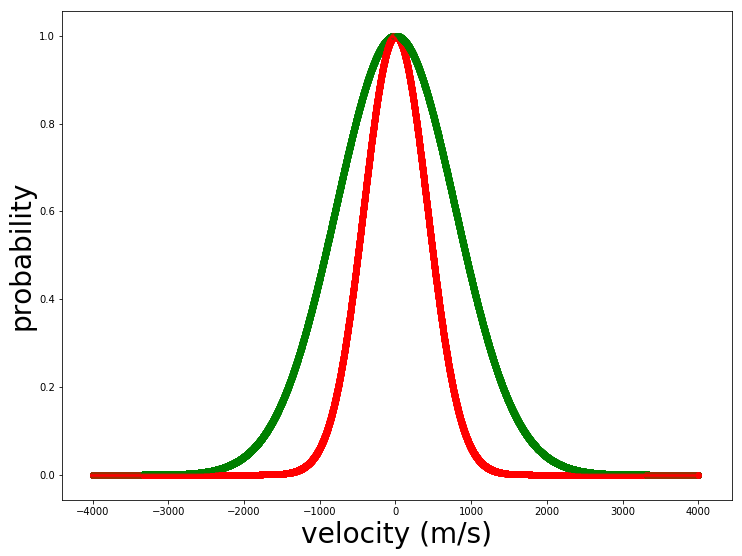

In [101]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)
ax.set_xlabel('velocity (m/s)', fontsize = '28')
ax.set_ylabel('probability', fontsize = '28')
for v in np.arange(-4000,4000,1):
    ax.scatter(v, max_boltz(v, 6.6464764e-27), color ='g')
    ax.scatter(v, max_boltz(v, 2.3258671e-26), color ='r')
plt.show()

789.525026796 0.444473561475


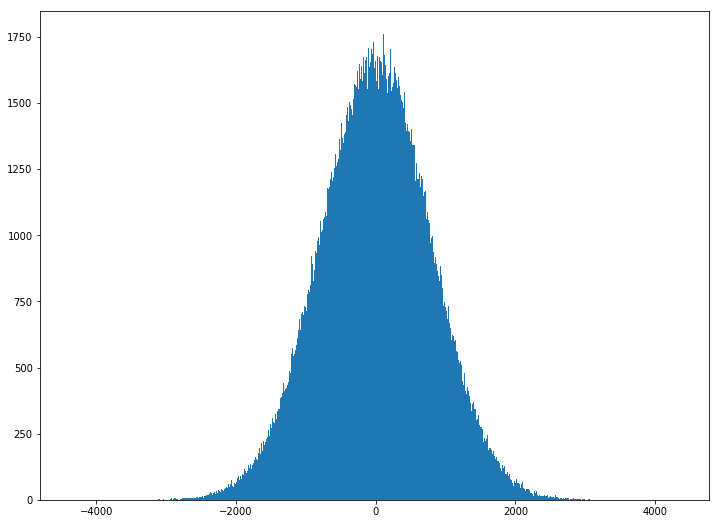

In [103]:
vmax = 6000
distribution = []
for i in range(10000000):
    v = vmax * random()
    p = random()
    pv = max_boltz(v, 6.6464764e-27)
    if p < pv:
        distribution.append(v)
    v = -vmax * random()
    p = random()
    pv = max_boltz(v, 6.6464764e-27)
    if p < pv:
        distribution.append(v)
        
print np.std(distribution), np.mean(distribution)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)
ax.hist(distribution, bins = np.arange(min(distribution), max(distribution)+10, 1))
plt.show()

In [104]:
print randint(0, len(distribution))

2050623


In [105]:
PCs = permanent_charges( Rp, 12 , cap_d, cap_vol, width( Rp, PHI), r)
p_ch_sep_angle = PCs[1][2]
no =  no_gas_particles(p_ch_sep_angle, width, r, 0.164, 6.6464764e-27)

In [106]:
bf = []
for i in np.arange(1e5):
    x = randint(0, len(distribution))
    bf.append(brownian_force(no, distribution[x], 1e-9, 6.6464764e-27))

In [111]:
bff = []
for item in bf:
    bff.append(item*1e29)

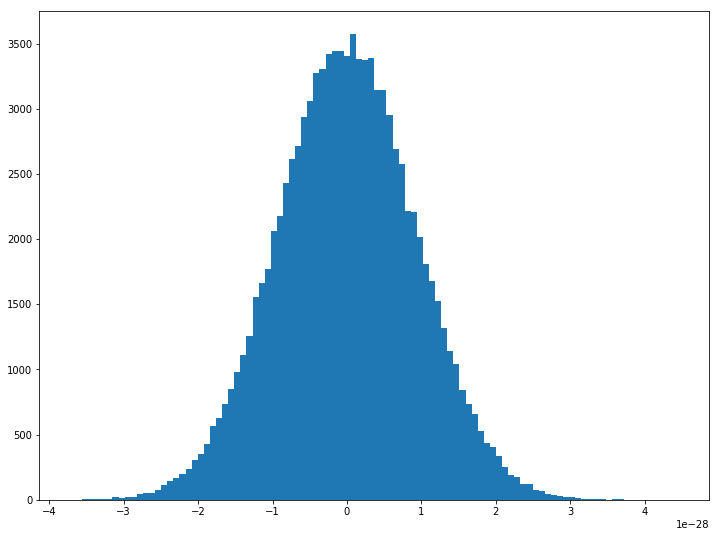

In [112]:
fig = plt.figure(figsize=(12, 9))
plt.hist(bf, 100)
plt.show()

421.783296255 0.639668483936


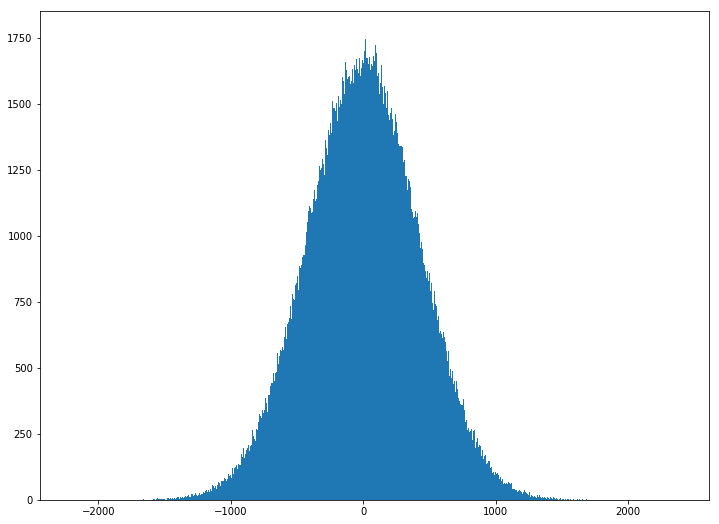

In [117]:
vmax = 6000
distribution = []
for i in range(10000000):
    v = vmax * random()
    p = random()
    pv = max_boltz(v, 2.3258671e-26)
    if p < pv:
        distribution.append(v)
    v = -vmax * random()
    p = random()
    pv = max_boltz(v, 2.3258671e-26)
    if p < pv:
        distribution.append(v)
        
print np.std(distribution), np.mean(distribution)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)
ax.hist(distribution, bins = np.arange(min(distribution), max(distribution)+10, 1))
plt.show()

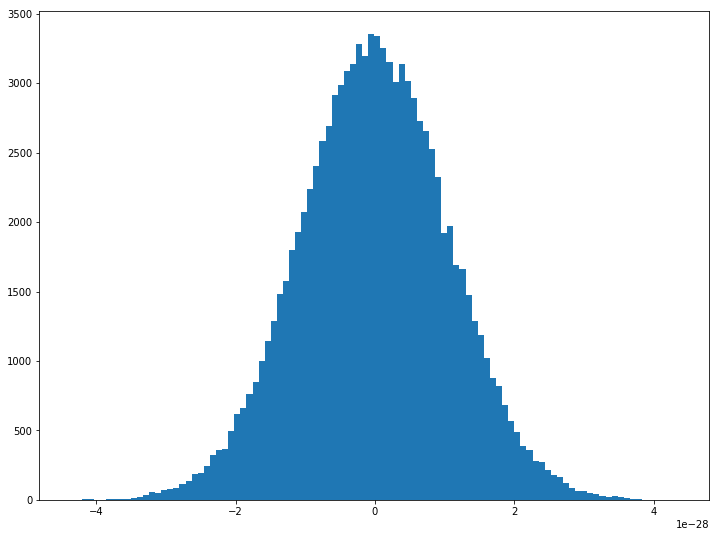

In [118]:
PCs = permanent_charges( Rp, 12 , cap_d, cap_vol, width( Rp, PHI), r)
p_ch_sep_angle = PCs[1][2]
no =  no_gas_particles(p_ch_sep_angle, width, r, 1.225, 2.3258671e-26)

bf = []
for i in np.arange(1e5):
    x = randint(0, len(distribution))
    bf.append(brownian_force(no, distribution[x], 1e-9, 6.6464764e-27))
    
fig = plt.figure(figsize=(12, 9))
plt.hist(bf, 100)
plt.show()

In [119]:
print no

37635


In [120]:
"""Active motor functions"""

def tangential_component(k , n, e, R, Rp, gamma, noc, width, r):
    """Calculates the tangential coulomb force on one inner charge"""
    F_c = 0; #coulomb force
    F_t = 0 #tangential component of coulumb force
    QDs = quantum_dots(n, e, noc) #calls function to initialize QDs
    for i in range(n):
        Q = QDs[i] #dictionary section on ith QD
        ri = math.sqrt(  ( (Rp-(r/4) )**2) + (R**2) - 2*(Rp-(r/4))*R*math.cos(QDs[i][2]-gamma) ) #distance between QD and permanent charge
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        if ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) > 1 or ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) < -1 : #accounts for computational error
            alpha = 0
        else:
            alpha = math.acos((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) #angle to tangential in which force vector acts
        if i > n/2:
            alpha = -alpha
        ex_minus = ri*math.sin(alpha) - (width/2)
        ex_plus = ri*math.sin(alpha) + (width/2)
        ey_minus = ri*math.cos(alpha)
        ey_plus = ri*math.cos(alpha) + (r/2)
        sigma = PCs[0][3]/(width*r)
        f = force(ex_minus, ex_plus, ey_minus, ey_plus)
        F_c = k*sigma*Q[3]*f #coulomb force between permanent charge and QD
        F_t += F_c*math.sin(alpha)
    return F_t

def force( c1, c2, c3, c4):
    a1 = (c4 + math.sqrt((c4**2)+(c1**2)))*(c3 + math.sqrt((c3**2)+(c2**2)))
    b1 = (c4 + math.sqrt((c4**2)+(c2**2)))*(c3 + math.sqrt((c3**2)+(c1**2)))
    a2 = (c2 + math.sqrt((c2**2)+(c3**2)))*(c1 + math.sqrt((c1**2)+(c4**2)))
    b2 = (c2 + math.sqrt((c2**2)+(c4**2)))*(c1 + math.sqrt((c1**2)+(c3**2)))
    I1 = math.log(a1/b1)
    I2 = math.log(a2/b2)
    f = math.sqrt( (I1**2) + (I2**2) )
    return f

def torque (F_t, Rp, p, r):
    """Computes torque on enitre inner rotor"""
    torque_radius = Rp - r/4
    torque = F_t * torque_radius * p
    return torque

In [127]:
print seperation_angle(80)
print seperation_angle(24)

0.0785398163397
0.261799387799


In [129]:
print tangential_component(k , n, e, R, Rp, 0.0785398163396, noc, width( Rp, PHI), r)
print tangential_component(k , n, e, R, Rp, 0.261799387798, noc, width( Rp, PHI), r)

2.66161168963e-10
-3.62131167725e-19
